In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import transforms, utils

import ImageDataset

from skimage import io, transform
from skimage.color import rgb2yuv
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
import os
import importlib
from datetime import date

import utils
import model
import Logger
import Discriminator
import building_blocks
import mask_generation
import ssim
import tv
import unet_model
import unet_parts
%matplotlib inline

/home/dmitrii/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
import os.path
import shutil

def remove_experiment(session):
    if os.path.exists("logs_lap_in/"+session):
        shutil.rmtree("logs_lap_in/"+session, ignore_errors=True)
    if os.path.exists(f"model/unet_in/G_{session}"):
        os.remove(f"model/unet_in/G_{session}")
    if os.path.exists(f"model/unet_in/D_{session}"):
        os.remove(f"model/unet_in/D_{session}")
    for i in range(6):
        if os.path.exists(f"model/unet_in/G_{session}_{i}"):
            os.remove(f"model/unet_in/G_{session}_{i}")
        if os.path.exists(f"model/unet_in/D_{session}_{i}"):
            os.remove(f"model/unet_in/D_{session}_{i}")

In [6]:
remove_experiment("encdec_moreiters_bnD_gatedconv_scheduler_myunet_cs_l1_lsgan_0307_bs16_lrg1e-04_lrd1e-04_advw7e-02_gpw1e+00")

In [26]:
directory = "../data/cityscapes/test/"
with open(directory + "test.flist", 'a') as file:
    for f in os.listdir(directory):
        filename = os.path.join(directory, f)
        file.write(filename+'\n')

In [8]:
l1 = nn.L1Loss(size_average=False, reduce=False)

In [15]:
torch.ones(3,4,5).sum(1).unsqueeze(2).size()

torch.Size([3, 5, 1])

In [3]:
a = torch.Tensor([3, 0.4, -2])
b = torch.ones(3)

In [9]:
l1(a, b)

tensor([ 2.0000,  0.6000,  3.0000])

In [7]:
torch.abs(a-b)

tensor([ 2.0000,  0.6000,  3.0000])

In [18]:
utils.get_n_params(G_net)

26594950

In [14]:
torch.ones(1,2,3).size(2)

3

In [9]:
G_net = unet_model.GrowableUNet(4, 64)

In [17]:
G_net.grow()

In [2]:
image_size = 256
bs_train = 8
bs_val = 8
train_dataset = ImageDataset.ImageDataset(["../data/cityscapes/train"], im_size=image_size,
                                          mean_color=[0.376, 0.434, 0.45], normalize=True)
data_loader = DataLoader(train_dataset, batch_size=bs_train, shuffle=True, pin_memory=True, num_workers=3)
val_dataset = ImageDataset.ImageDataset(["../data/cityscapes/test"], im_size=image_size,
                                        mean_color=[0.376, 0.434, 0.45], normalize=True)
val_loader = DataLoader(train_dataset, batch_size=bs_val, shuffle=True, pin_memory=True, num_workers=3)
mask_gen = mask_generation.MaskGenerator(im_size=image_size)

In [3]:
# block_config=(6, 12, 24, 16)
parallel = True
levels = 3
# G_net = model.LapIN(block_config=block_config, bn=False).cuda()
G_net = unet_model.UNet(4, 64).cuda()

D_net = Discriminator.Discriminator(input_size=image_size, #//2**(levels-1), 
                                  input_channels=4).cuda()

rec_criterion = nn.L1Loss().cuda() #nn.MSELoss().cuda()
# ssim_criterion = ssim.SSIMLoss(window_size=5)
tv_criterion = tv.TVLoss()
l1_error = nn.L1Loss().cuda()
l2_error = nn.MSELoss().cuda()
adv_criterion = nn.BCELoss().cuda()

adv_loss_weight = 0.015
tv_loss_weight = 0.05

In [ ]:
lrg = 1e-4
optimizerG = optim.Adam(G_net.parameters(), lr=lrg, betas=(0.5, 0.999))
schedulerG = optim.lr_scheduler.ReduceLROnPlateau(optimizerG, 'min', factor=0.4, patience=20)

In [ ]:
lrd = 1e-3
D_optimizer = optim.Adam(D_net.parameters(), lr=lrd, betas=(0.5, 0.999))
schedulerD = optim.lr_scheduler.ReduceLROnPlateau(D_optimizer, 'min', factor=0.4, patience=20)

In [7]:
if parallel:
    G_net = torch.nn.DataParallel(G_net).cuda()
    D_net = torch.nn.DataParallel(D_net).cuda()
#     for i in range(levels-1):
#         D_nets[i] = torch.nn.DataParallel(D_nets[i])

In [5]:
G_net.load_state_dict(torch.load('model/lap_in/G_noresidual_myunet_cs_l1_ssim_lsgan_2305_bs32_lrg5e-05_lrd5e-04_advw1e-03_ssimw5e-02'), strict=False)
D_net.load_state_dict(torch.load('model/lap_in/D_noresidual_myunet_cs_l1_ssim_lsgan_2305_bs32_lrg5e-05_lrd5e-04_advw1e-03_ssimw5e-02'), strict=False)

In [18]:
G_net = G_net.module
D_net = D_net.module

In [4]:
session = "scheduler_myunet_cs_l1_tv_lsgan_{}_bs{}_lrg{:.0e}_lrd{:.0e}_advw{:.0e}_tvw{:.0e}".format(
    date.today().strftime('%d%m'), bs_train, lrg, lrd, adv_loss_weight, tv_loss_weight)
logger = Logger.Logger('./logs_lap_in', session)
log_step=0
x2_downsampler = nn.AvgPool2d(2)
val_iters = 4
for epoch in range(10001):
    for i, input_batch in enumerate(data_loader):
        gt = input_batch.cuda()
        batch_size = gt.size(0)
        mask, mask_region_y, mask_region_x = mask_gen.generate_mask()
        imp_mask = Variable(mask.clone()).cuda(async=parallel)
        mask[mask>0]=1
        mask = mask.cuda(async=parallel)
        distorted = gt * (1-mask) + train_dataset.background.cuda() * mask
        distorted = torch.cat((distorted, mask.expand(batch_size, -1, -1, -1)), dim=1)
        G_output = G_net(Variable(distorted))
           
#         real_labels = Variable(torch.ones(batch_size).cuda(async=parallel))
#         fake_labels = Variable(torch.zeros(batch_size).cuda(async=parallel))
#         lowres_gt = x2_downsampler(x2_downsampler(Variable(gt)))
#         lowres_mask = x2_downsampler(x2_downsampler(Variable(mask)))
        lowres_gt = Variable(gt)
        lowres_mask = Variable(mask)
        lowres_mask_expanded = lowres_mask.expand(batch_size, -1, -1, -1)
        D_net.zero_grad()
        D_real_output = D_net(torch.cat((lowres_gt, lowres_mask_expanded), dim=1))
        errD_real = torch.mean((D_real_output - 1)**2)
        pred = lowres_mask*G_output[2] + (1-lowres_mask)*lowres_gt
        D_fake_output = D_net(torch.cat((pred.detach(), lowres_mask_expanded), dim=1))
#         errD_fake = adv_criterion(D_fake_output, fake_labels)
        errD_fake = torch.mean(D_fake_output**2)
        errD = 0.5 * (errD_real + errD_fake)
        errD.backward()
        D_optimizer.step()

        G_net.zero_grad()
        rec_losses = []
        tv_losses = []
#         GD_losses = [0] * (levels-1)
        current_size = image_size
        current_gt = Variable(gt.clone())
        current_mask = Variable(mask.clone())
        current_imp_mask = imp_mask.clone()
        # Training the generator.
        for level in range(levels):
            prediction = current_mask * G_output[-level-1] + (1-current_mask) * current_gt
            
            rec_losses.append(rec_criterion(G_output[-level-1] * current_imp_mask, current_gt * current_imp_mask) +
                              1/6*rec_criterion(G_output[-level-1] * (1-current_mask), current_gt * (1-current_mask)))
            tv_losses.append(tv_criterion(prediction))
                        
            if level == 0:
                DG_fake_output = D_net(torch.cat((prediction, lowres_mask_expanded), dim=1))
#                 err_DG = adv_criterion(DG_fake_output, real_labels)
                err_DG = 0.5 * torch.mean((DG_fake_output - 1)**2)
#                 GD_losses[level-1] += err_DG
                          
            if level != levels-1:
                current_mask= x2_downsampler(current_mask)
                current_imp_mask= x2_downsampler(current_imp_mask)
                current_gt = x2_downsampler(current_gt)
                current_size = current_size//2
        
        total_rec = sum(rec_losses)
        total_tv = sum(tv_losses)
        errG = adv_loss_weight*err_DG + tv_loss_weight*total_tv + total_rec
        errG.backward()
        optimizerG.step()
        
        raise Exception("blup")
        
        if i % 3000 == 0 and epoch % 5 == 0:
            log_step +=1
            print("D loss: {:.4f}, G_rec loss: {:.4f}, G_D loss: {:.4f}, TV: {:.4f}".format(
                errD_real.data[0] + errD_fake.data[0], total_rec.data[0], err_DG.data[0], total_tv.data[0]))

            #============ TensorBoard logging ============#
            # (1) Log the scalar values
            for lvl in range(levels):
                logger.scalar_summary("rec_train_{}".format(lvl+1), rec_losses[lvl].data[0], log_step)
                logger.scalar_summary("tv_train_{}".format(lvl+1), tv_losses[lvl].data[0], log_step)
            logger.scalar_summary("errD_real", errD_real.data[0], log_step)
            logger.scalar_summary("errD_fake", errD_fake.data[0], log_step)
            logger.scalar_summary("errGD", err_DG.data[0], log_step)
            logger.scalar_summary("total G", errG.data[0], log_step)
            logger.scalar_summary("total train rec", total_rec.data[0], log_step)
            logger.scalar_summary("total train tv", total_tv.data[0], log_step)
            
            del gt, G_output
            torch.cuda.empty_cache()
            
            l1_val_losses=[0]*levels
            l2_val_losses=[0]*levels
            ssim_val=[0]*levels
            tv_val=[0]*levels
            for val_iter, val_batch in enumerate(val_loader):
                if val_iter >= val_iters:
                    break
                
                val_gt = val_batch.cuda()
                val_batch_size = val_gt.size(0)
                mask, mask_region_y, mask_region_x = mask_gen.generate_mask()
                imp_mask = Variable(mask.clone()).cuda(async=parallel)
                mask[mask>0]=1
                mask = mask.cuda(async=parallel)
                distorted = val_gt * (1-mask) + train_dataset.background.cuda() * mask
                distorted = torch.cat((distorted, mask.expand(val_batch_size, -1, -1, -1)), dim=1)
                G_output = G_net(Variable(distorted))
                
                ind = np.random.randint(0, val_batch_size)
                current_gt = Variable(val_gt)
                current_mask = Variable(mask)
                current_imp_mask = imp_mask
                for lvl in range(levels):
                    prediction = current_mask * G_output[-lvl-1] + (1-current_mask) * current_gt
                    l1_err = l1_error(prediction, current_gt).data[0]
                    l1_val_losses[lvl] += l1_err
                    l2_err = l2_error(prediction, current_gt).data[0]
                    l2_val_losses[lvl] += l2_err
                    ssim_err = ssim.ssim(prediction, current_gt).data[0]
                    ssim_val[lvl] += ssim_err
                    tv_err = tv_criterion(prediction).data[0]
                    tv_val[lvl] += tv_err
                    sample_to_log = prediction[ind].data.cpu().numpy()
                    logger.image_summary('val_image_{}'.format(log_step), [sample_to_log], epoch+1)
                    if lvl != levels-1:
                        current_mask= x2_downsampler(current_mask)
                        current_gt = x2_downsampler(current_gt)

            for lvl in range(levels):
                logger.scalar_summary("l1_val_{}".format(lvl+1), l1_val_losses[lvl]/val_iters, log_step)
                logger.scalar_summary("l2_val_{}".format(lvl+1), l2_val_losses[lvl]/val_iters, log_step)
                logger.scalar_summary("ssim_val_{}".format(lvl+1), ssim_val[lvl]/val_iters, log_step)
                logger.scalar_summary("tv_val_{}".format(lvl+1), tv_val[lvl]/val_iters, log_step)
                
            del val_gt, G_output
            torch.cuda.empty_cache()

            torch.save(D_net.state_dict(), 'model/unet_in/D_'+session)
            torch.save(G_net.state_dict(), 'model/unet_in/G_'+session)
    
    schedulerG.step(errG.data[0])
    schedulerD.step(errG.data[0])

Exception: blup

In [ ]:
def get_lr

In [ ]:
session = "upconv_no_bn_{}_bs{}_lrg{:.0e}_lrd{:.0e}_advw{:.0e}".format(date.today().strftime('%d%m'), bs_train, lrg, lrd, adv_loss_weight)
logger = Logger.Logger('./logs_lap_in', session)
log_step=0
x2_downsampler = nn.AvgPool2d(2)
val_iters = 5
for epoch in range(101):
    for i, input_batch in enumerate(data_loader):
        gt = input_batch.cuda()
        batch_size = gt.size(0)
        mask, mask_region_y, mask_region_x = mask_gen.generate_mask()
        imp_mask = Variable(mask.clone()).cuda(async=parallel)
        mask[mask>0]=1
        mask = mask.cuda(async=parallel)
        distorted = gt * (1-mask) + train_dataset.background.cuda() * mask
        distorted = torch.cat((distorted, mask.expand(batch_size, -1, -1, -1)), dim=1)
        G_output = G_net(Variable(distorted))
           
        real_labels = Variable(torch.ones(batch_size).cuda(async=parallel))
        fake_labels = Variable(torch.zeros(batch_size).cuda(async=parallel))
        adv_losses = [0] * (levels-1)
        current_size = image_size
        current_gt = Variable(gt.clone())
        current_mask = Variable(mask.clone())
        # Training the discriminators.
        for level in range(levels):
            prediction = current_mask * G_output[-level-1] + (1-current_mask) * current_gt
#             if level != levels-1:
#                 y = int(mask_region_y / (2**(level)))
#                 x = int(mask_region_x / (2**(level)))
#                 close_up_slice = (..., slice(y, y+current_size//2), slice(x, x+current_size//2))
                
#                 D_nets[level].zero_grad()
#                 D_real_output = D_nets[level](current_gt[close_up_slice])
#                 errD_real = adv_criterion(D_real_output, real_labels)
#                 errD_real.backward()

#                 D_fake_output = D_nets[level](prediction[close_up_slice].detach())
#                 errD_fake = adv_criterion(D_fake_output, fake_labels)
#                 errD_fake.backward()              
            if level != 0:
                D_nets[level-1].zero_grad()
                D_real_output = D_nets[level-1](current_gt)
                errD_real = adv_criterion(D_real_output, real_labels)
                errD_real.backward()

                D_fake_output = D_nets[level-1](prediction.detach())
                errD_fake = adv_criterion(D_fake_output, fake_labels)
                errD_fake.backward()
                D_optimizers[level-1].step()
            
            if level != levels-1:
                current_mask= x2_downsampler(current_mask)
                current_gt = x2_downsampler(current_gt)
                current_size = current_size//2

        G_net.zero_grad()
        l2_losses = []
#         GD_losses = [0] * (levels-1)
        current_size = image_size
        current_gt = Variable(gt.clone())
        current_mask = Variable(mask.clone())
        current_imp_mask = imp_mask.clone()
        # Training the generator.
        for level in range(levels):
            prediction = current_mask * G_output[-level-1] + (1-current_mask) * current_gt
            l2_losses.append(l2_criterion(prediction * current_imp_mask, current_gt * current_imp_mask))
                        
            if level == 2:
                DG_fake_output = D_nets[level-1](prediction)
                err_DG_1 = adv_criterion(DG_fake_output, real_labels)
#                 GD_losses[level-1] += err_DG
                
            if level == 0:
                y = int(mask_region_y / (2**(level)))
                x = int(mask_region_x / (2**(level)))
                close_up_slice = (..., slice(y, y+current_size//2), slice(x, x+current_size//2))
                
                DG_fake_output = D_nets[level](prediction[close_up_slice])
                err_DG_0 = adv_criterion(DG_fake_output, real_labels)
#                 GD_losses[level] += err_DG
                
            if level != levels-1:
                current_mask= x2_downsampler(current_mask)
                current_imp_mask= x2_downsampler(current_imp_mask)
                current_gt = x2_downsampler(current_gt)
                current_size = current_size//2
        
        total_GD = err_DG_0 + err_DG_1
        total_l2 = sum(l2_losses)
        errG = adv_loss_weight*total_GD + total_l2
        errG.backward()
        optimizerG.step()
        
        if i % 300 == 0:
            log_step +=1
            print("D loss: {:.4f}, G_L2 loss: {:.4f}, G_D loss: {:.4f}".format(
                errD_real.data[0] + errD_fake.data[0], total_l2.data[0], total_GD.data[0]))

            #============ TensorBoard logging ============#
            # (1) Log the scalar values
            for lvl in range(levels):
                logger.scalar_summary("l2_train_{}".format(lvl+1), l2_losses[lvl].data[0], log_step)
#                 if lvl != levels - 1:
#                     logger.scalar_summary("GD_{}".format(lvl+1), GD_losses[lvl].data[0], log_step)
            logger.scalar_summary("GD_0", err_DG_0.data[0], log_step)
            logger.scalar_summary("GD_1", err_DG_1.data[0], log_step)        
            logger.scalar_summary("errD_real", errD_real.data[0], log_step)
            logger.scalar_summary("errD_fake", errD_fake.data[0], log_step)
            logger.scalar_summary("total GD", total_GD.data[0], log_step)
            logger.scalar_summary("train L2", total_l2.data[0], log_step)
            
            del gt, G_output
            torch.cuda.empty_cache()
            
            l2_val_losses=[0]*levels
            for val_iter, val_batch in enumerate(val_loader):
                if val_iter >= val_iters:
                    break
                
                val_gt = val_batch.cuda()
                val_batch_size = val_gt.size(0)
                mask, mask_region_y, mask_region_x = mask_gen.generate_mask()
                imp_mask = Variable(mask.clone()).cuda(async=parallel)
                mask[mask>0]=1
                mask = mask.cuda(async=parallel)
                distorted = val_gt * (1-mask) + train_dataset.background.cuda() * mask
                distorted = torch.cat((distorted, mask.expand(val_batch_size, -1, -1, -1)), dim=1)
                G_output = G_net(Variable(distorted))
                
                ind = np.random.randint(0, val_batch_size)
                current_gt = Variable(val_gt)
                current_mask = Variable(mask)
                current_imp_mask = imp_mask
                for lvl in range(levels):
                    prediction = current_mask * G_output[-lvl-1] + (1-current_mask) * current_gt
                    l2_loss = l2_criterion(prediction * current_imp_mask, current_gt * current_imp_mask).data[0]
                    l2_val_losses[lvl] += l2_loss
                    sample_to_log = prediction[ind].data.cpu().numpy()
                    logger.image_summary('val_image_{}_{}'.format(epoch, i//300+1), [sample_to_log], epoch+1)
                    if lvl != levels-1:
                        current_mask= x2_downsampler(current_mask)
                        current_imp_mask= x2_downsampler(current_imp_mask)
                        current_gt = x2_downsampler(current_gt)

            for lvl, l2_val in enumerate(l2_val_losses):
                logger.scalar_summary("l2_val_{}".format(lvl+1), l2_val/val_iters, log_step)
                
            del val_gt, G_output
            torch.cuda.empty_cache()
            
            
#                 # (2) Log examples of filled output images
                
#                 sample_gt = Variable(val_batch[ind].cuda())
#                 for level in range(1, levels+1):
#                     pred = (mask_pyramid[level-1][ind] * G_output[-level][ind] + \
#                                          (1-mask_pyramid[level-1][ind]) * gt).data.cpu().numpy()
#                     logger.image_summary('images_{}_{}'.format(epoch, i//300+1), [pred], epoch+1)
#                     if level != levels:
#                         gt = x2_downsampler(gt)

            for lvl, D_net in enumerate(D_nets):
                torch.save(D_net.state_dict(), 'model/lap_in/D{}_checkpoint_2304'.format(lvl))
            torch.save(G_net.state_dict(), 'model/lap_in/G_checkpoint_2304')

/home/dmitrii/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1189: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


D loss: 1.4413, G_L2 loss: 0.0985, G_D loss: 1.5689
D loss: 1.2489, G_L2 loss: 0.0266, G_D loss: 1.5351
D loss: 1.3820, G_L2 loss: 0.0054, G_D loss: 1.2806
D loss: 1.3614, G_L2 loss: 0.0098, G_D loss: 1.4021


/home/dmitrii/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1189: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([22, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


D loss: 1.4033, G_L2 loss: 0.0048, G_D loss: 1.2841
D loss: 1.3535, G_L2 loss: 0.0121, G_D loss: 1.6181
D loss: 1.3415, G_L2 loss: 0.0071, G_D loss: 1.3998
D loss: 1.3822, G_L2 loss: 0.0052, G_D loss: 1.2602
D loss: 1.3215, G_L2 loss: 0.0096, G_D loss: 1.7519
D loss: 1.2838, G_L2 loss: 0.0078, G_D loss: 1.5741
D loss: 1.2843, G_L2 loss: 0.0136, G_D loss: 2.0073
D loss: 1.3643, G_L2 loss: 0.0072, G_D loss: 1.7992
D loss: 1.3657, G_L2 loss: 0.0066, G_D loss: 1.5063
D loss: 1.3264, G_L2 loss: 0.0114, G_D loss: 1.4463
D loss: 1.2719, G_L2 loss: 0.0062, G_D loss: 1.5983
D loss: 1.2606, G_L2 loss: 0.0055, G_D loss: 1.0818
D loss: 1.3331, G_L2 loss: 0.0057, G_D loss: 1.1627
D loss: 1.1703, G_L2 loss: 0.0105, G_D loss: 1.8806
D loss: 1.3383, G_L2 loss: 0.0043, G_D loss: 1.0215
D loss: 1.4295, G_L2 loss: 0.0049, G_D loss: 1.3293
D loss: 1.0024, G_L2 loss: 0.0143, G_D loss: 1.4594
D loss: 1.3835, G_L2 loss: 0.0057, G_D loss: 1.3735
D loss: 1.1231, G_L2 loss: 0.0099, G_D loss: 1.1716
D loss: 1.18

In [9]:
torch.cuda.empty_cache()

In [ ]:
utils.get_n_params(G_net)

In [248]:
#G_net.load_state_dict(torch.load('model/lap_in/G_checkpoint_1103'))
#lowres_D.load_state_dict(torch.load('model/lap_in/lowres_D_checkpoint_1103'))

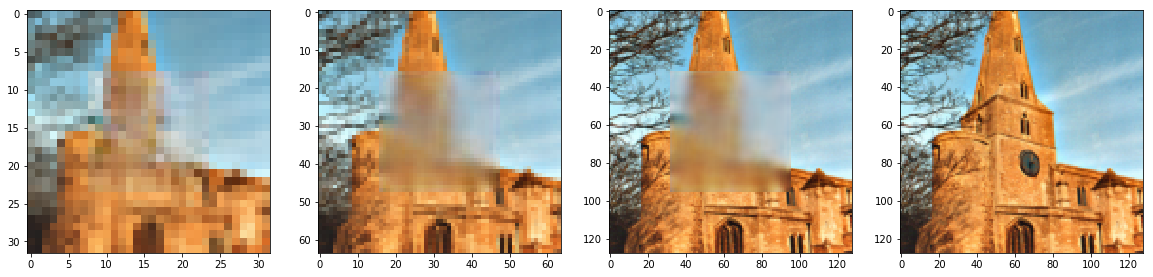

In [319]:
plot_several(transforms.ToPILImage()((img['gt']+1)/2), outs)